In [ ]:
# Install packages if needed with this command: 
# !pip install -r requirements.txt
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, f1_score, recall_score
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


# 1. Load dataset


In [3]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset', 
                                    path=data_dir, unzip=True)

In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f: 
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f: 
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]), 
                                label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f: 
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]), 
                               label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f: 
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]), 
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


# 2. Visualise data and plot data distribution

There are 6 classes and that classes are represented as unique integers. Therefore as the assignment desribes, we can use a one hot encoding for the class element of each sample, transforming the integer into a 6 element binary vector with a 1 for the index of the class value. We can achieve this with the `to_categorical()` function. (FROM PRACTICAL 2)

In [ ]:
# Convert the target testues using the proper function for one hot encoding.
## CONFUSED AS THEY ARE ALREADY IN ONE HOT ENCODING
from tensorflow.keras.utils import to_categorical

# Extract the number of target classes
num_classes = len(np.unique(train_data.classes))

# one-hot encode the integer labels
y_train = to_categorical(train_data.classes, num_classes=num_classes)
y_test = to_categorical(test_data.classes, num_classes=num_classes)
y_test = to_categorical(test_data.classes, num_classes=num_classes)


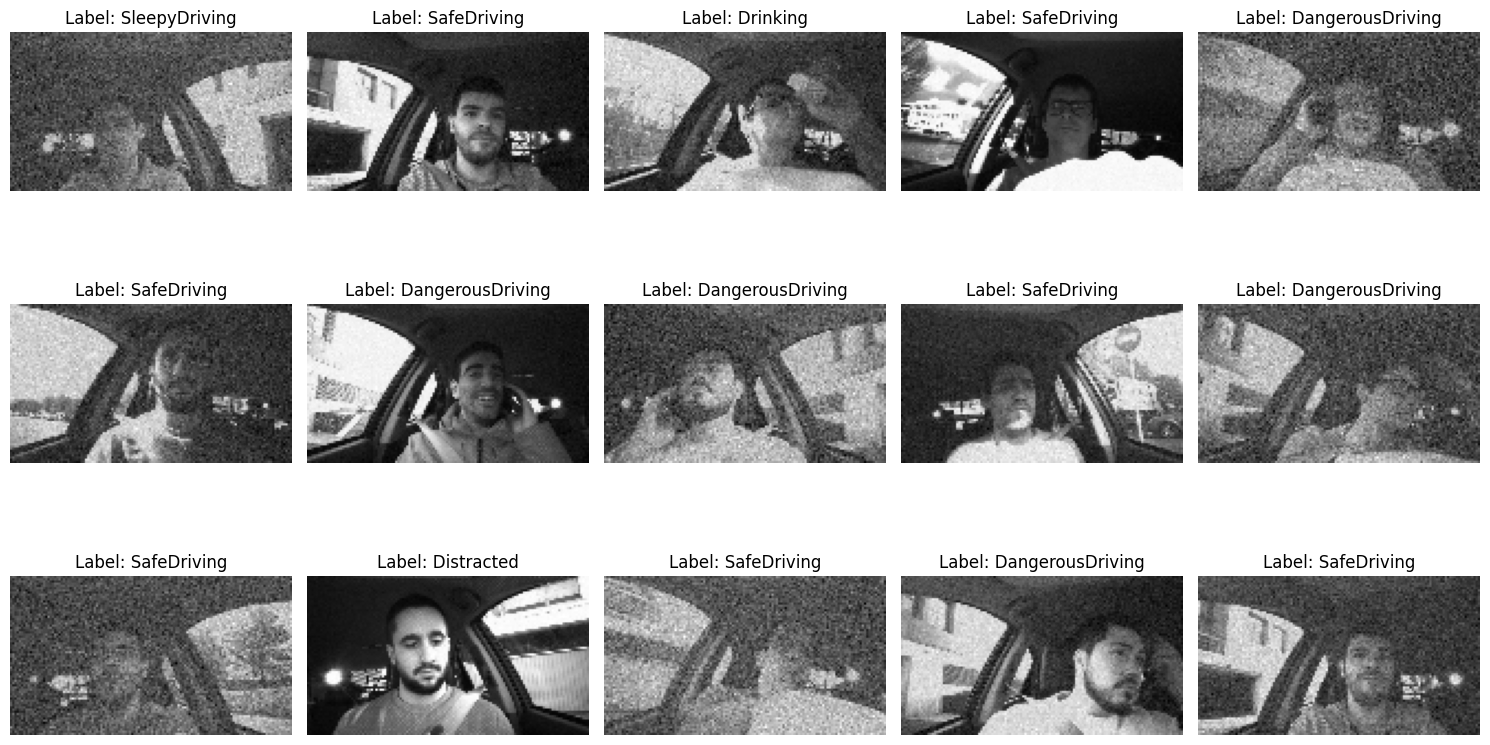

In [6]:
# Randomly select 15 samples from the dataset. For each selected sample, display the image along with its corresponding label as text on top of the image. 
# Arrange 2 these images and labels in a single figure, ensuring that they are visually clear and labeled properly

# Get images and labels from the training data
images, labels = next(train_data)
# images.shape => (32, 72, 128, 1)  # batch_size=32, H=72, W=128, 1=grayscale
# labels.shape => (32, 6)          # one-hot vectors for 6 classes

    
# Randomly select 15 samples
num_samples = 15
random_indices = np.random.choice(len(images), size = num_samples, replace=False)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Get class names from the training data
class_names = list(train_data.class_indices.keys())

# Create a figure and axes for the images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(num_samples):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images
    
    label_onehot = selected_labels[i]

    # Decode the label: one-hot => class index => class name
    label_onehot = selected_labels[i] # Encodde every class index one-hot
    label_index = np.argmax(label_onehot) # Matrix with 0-1 diagnoal
    label_name = class_names[label_index] # attach label_name to each index

    # ---- Plot the image ----
    ax.imshow(image_squeezed, cmap='gray')
    ax.set_title(f"Label: {label_name}")
    ax.axis('off')
plt.tight_layout()
plt.show()

[3, 3, 2, 0, 3, 3, 0, 3, 3, 3, 0, 1, 3, 0, 0, 3, 1, 0, 3, 3, 0, 3, 0, 0, 0, 4, 3, 3, 3, 0, 3, 0, 0, 5, 0, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 1, 0, 3, 3, 2, 3, 3, 1, 0, 1, 3, 0, 3, 3, 3, 1, 5, 3, 3, 3, 3, 0, 3, 3, 1, 3, 4, 3, 3, 0, 1, 1, 3, 1, 3, 3, 0, 3, 2, 1, 5, 3, 3, 2, 0, 3, 5, 3, 3, 0, 3, 3, 1, 4, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 5, 0, 3, 3, 3, 0, 1, 3, 3, 1, 3, 1, 0, 1, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 2, 2, 3, 3, 3, 0, 0, 1, 5, 1, 4, 0, 0, 3, 3, 3, 1, 0, 1, 1, 3, 0, 3, 0, 3, 3, 0, 3, 1, 3, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 1, 0, 3, 0, 0, 3, 0, 3, 1, 1, 0, 1, 3, 0, 0, 5, 3, 0, 4, 0, 3, 0, 3, 1, 1, 0, 0, 0, 3, 5, 3, 4, 3, 4, 3, 3, 3, 0, 3, 0, 0, 3, 3, 4, 0, 3, 0, 1, 0, 3, 3, 0, 0, 3, 0, 1, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 1, 1, 0, 3, 3, 3, 1, 5, 3, 0, 0, 3, 1, 5, 4, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 1, 0, 4, 5, 0, 0, 0, 3, 0, 4, 3, 3, 5, 1, 3, 3, 0, 5, 3, 0, 3, 3, 0, 3, 0, 1, 0, 4, 0, 0, 1, 0, 1, 3, 2, 3, 3, 0, 1, 0, 

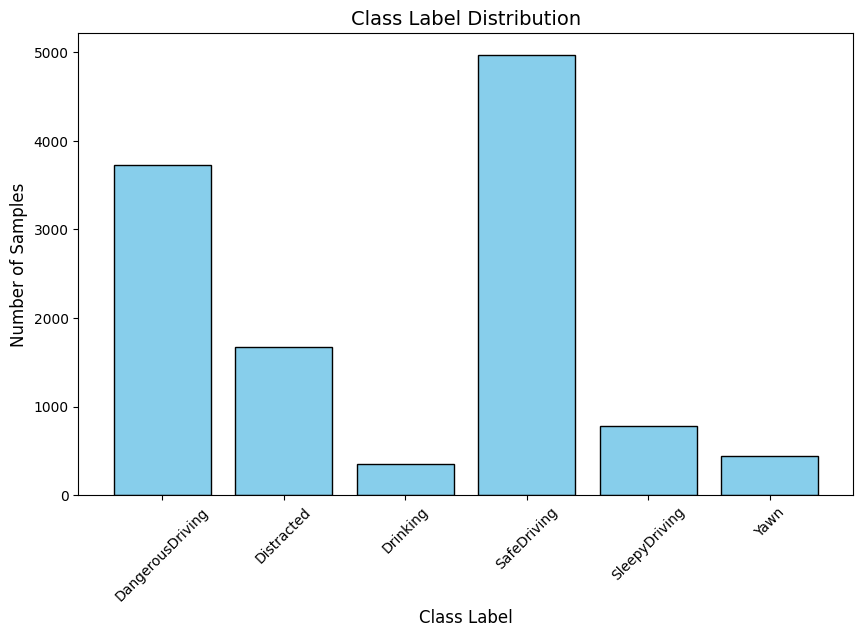

In [7]:
### OWN CODe
## As done in the previous section; extract class names, from training data
train_labels = train_data.classes
print(train_labels)
class_names = list(train_data.class_indices.keys())
print(class_names)

# Create a pandas dataframe, to count the occurence of each class
## Reindex length to make sure the mapping is correct, without reindex label and counts are not correctly attached
class_counts = pd.Series(train_labels).value_counts().reindex(range(len(class_names)))
print(class_counts)

plt.figure(figsize=(10,6))
plt.bar(class_names, class_counts, color="skyblue", edgecolor="black")
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Class Label Distribution", fontsize=14)
plt.xticks(rotation=45)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.show()

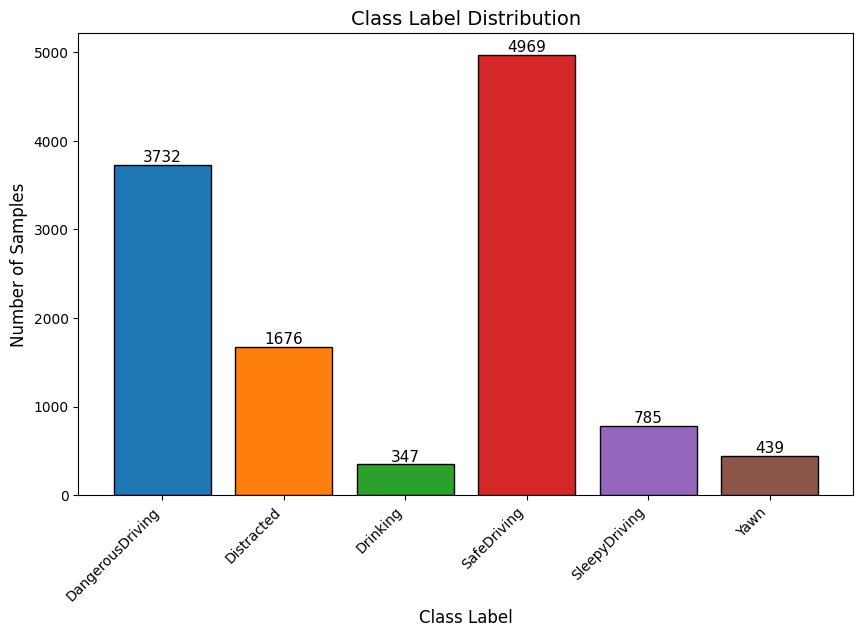

In [8]:
# Create a bar plot to visualize the class label distribution of the dataset. (Hint: this bar plot reveals how many samples the dataset has for each class)

### CHATGPT INPROVEMENTS
train_labels = train_data.classes
class_names = list(train_data.class_indices.keys())
class_counts = pd.Series(train_labels).value_counts().reindex(range(len(class_names)), fill_value=0)
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors 
bars = plt.bar(class_names, class_counts, color=colors, edgecolor="black")
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=11, color='black')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Class Label Distribution", fontsize=14)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha="right")
plt.show()


In [9]:
input_shape = (img_height, img_width,1 )
# Baseline CNN Algorithm per Figure 2
model = models.Sequential()

# 1st Convolutional layer with 8 output channels, 3x3 kernel size, followed by a MaxPooling layer (2x2)
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(input_shape)))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional layer with 8 output channels, 3x3 kernel size, followed by another MaxPooling layer (2x2) model
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3nd Convolutional layer with 8 output channels, 3x3 kernel size, followed by another MaxPooling layer (2x2) model
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the convolutional layers
model.add(layers.Flatten())

# Fully connected (Dense) layer with 32 units and Relu activation function
model.add(layers.Dense(10, activation='relu'))

# Output layer of size 6  (for classification) and softmax activation function
model.add(layers.Dense(6, activation='softmax'))

# Print the model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 126, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 61, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 14, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model with 10 epochs (batch size is set to 32 as part of the provided prepro-
# cessing code). The optimizer should be Adam, the metric should be accuracy and the
# loss function is expected from you :-).

# Compiling the model
model.compile(optimizer='Adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

epochs = 10
history = model.fit(train_data, validation_data=val_data, 
          epochs=10, batch_size=32, verbose=1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.4626 - loss: 1.3285 - val_accuracy: 0.6748 - val_loss: 0.9009
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6709 - loss: 0.8734 - val_accuracy: 0.7112 - val_loss: 0.7574
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7318 - loss: 0.7404 - val_accuracy: 0.7560 - val_loss: 0.6810
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7670 - loss: 0.6488 - val_accuracy: 0.7836 - val_loss: 0.6272
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7795 - loss: 0.6028 - val_accuracy: 0.8054 - val_loss: 0.5816
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.7931 - loss: 0.5669 - val_accuracy: 0.8049 - val_loss: 0.5677
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8050 - loss: 0.5309 - val_accuracy: 0.8132 - val_loss: 0.5456
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.8207 - loss: 0.5054 - val_accurac

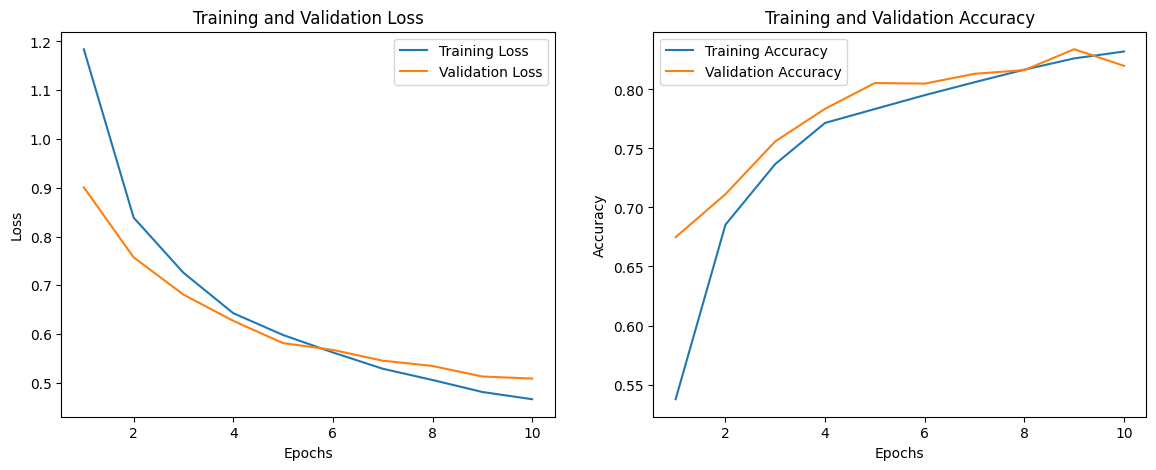

In [11]:
# Analyze the performance of the baseline by plotting: (i) the training and validation
# losses and accuracies on the training and validation set through epochs, 

def plot_training_history(history):
    epochs = range(1, len(history.epoch) + 1)

    # Plot Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

# Call the function with your model's history
plot_training_history(history)

In [18]:
# Initialize lists VAL
y_true_val_one_hot = []
y_score_val = []  # For ROC (softmax probabilities)
y_true_val = []       # For Confusion Matrix & Classification Metrics (discrete labels)
y_pred_val = []       # For Confusion Matrix & Classification Metrics (discrete labels)

for i in range(len(val_data)):
    image, label = val_data[i]

    # Store true labels (both one-hot and argmax versions)
    y_true_val_one_hot.append(label)  # One-hot encoded (needed for ROC)
    y_true_val.append(np.argmax(label, axis=1))  # Integer class labels (needed for other metrics)

    # Get model predictions
    y_score_batch = model.predict(image)  # Raw probabilities (needed for ROC)
    y_pred_batch = np.argmax(y_score_batch, axis=1)  # Class labels (needed for confusion matrix, etc.)

    # Store predictions
    y_score_val.append(y_score_batch)  # Softmax probabilities
    y_pred_val.append(y_pred_batch)  # Argmax labels

# Convert lists to numpy arrays
y_true_val_one_hot = np.concatenate(y_true_val)
y_score_val = np.concatenate(y_score_val)
y_true_val = np.concatenate(y_true_val)
y_pred_val = np.concatenate(y_pred_val)

# TEST 
# Initialize lists Test
y_true_test_one_hot = []
y_score_test = []  # For ROC (softmax probabilities)
y_true_test = []       # For Confusion Matrix & Classification Metrics (discrete labels)
y_pred_test= []       # For Confusion Matrix & Classification Metrics (discrete labels)

for i in range(len(test_data)):
    image, label = test_data[i]

    # Store true labels (both one-hot and argmax versions)
    y_true_test_one_hot.append(label)  # One-hot encoded (needed for ROC)
    y_true_test.append(np.argmax(label, axis=1))  # Integer class labels (needed for other metrics)

    # Get model predictions
    y_score_batch = model.predict(image)  # Raw probabilities (needed for ROC)
    y_pred_batch = np.argmax(y_score_batch, axis=1)  # Class labels (needed for confusion matrix, etc.)

    # Store predictions
    y_score_test.append(y_score_batch)  # Softmax probabilities
    y_pred_test.append(y_pred_batch)  # Argmax labels

# Convert lists to numpy arrays
y_true_test_one_hot = np.concatenate(y_true_test)
y_score_test = np.concatenate(y_score_test)
y_true_test = np.concatenate(y_true_test)
y_pred_test = np.concatenate(y_pred_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

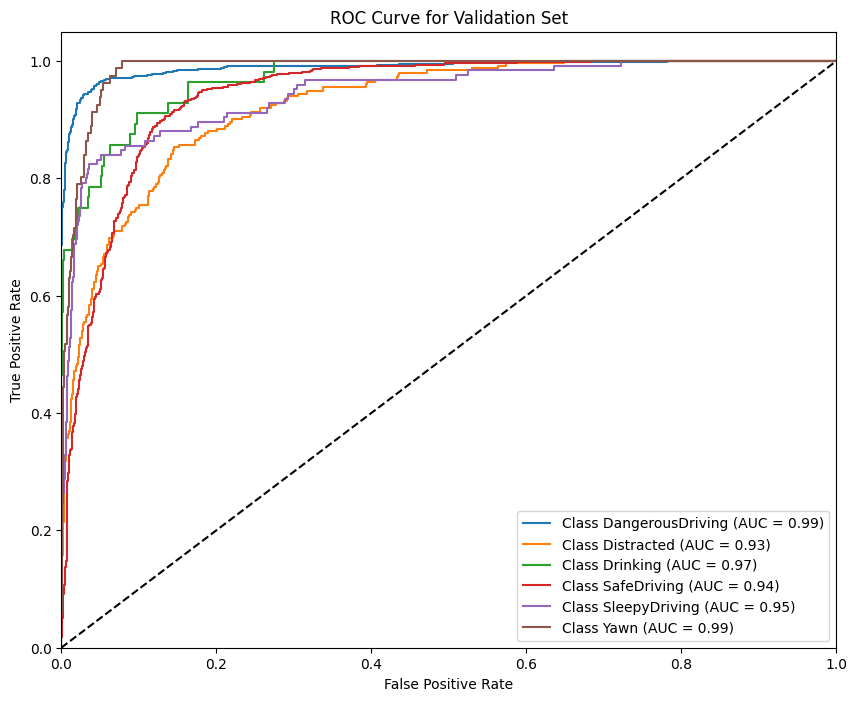

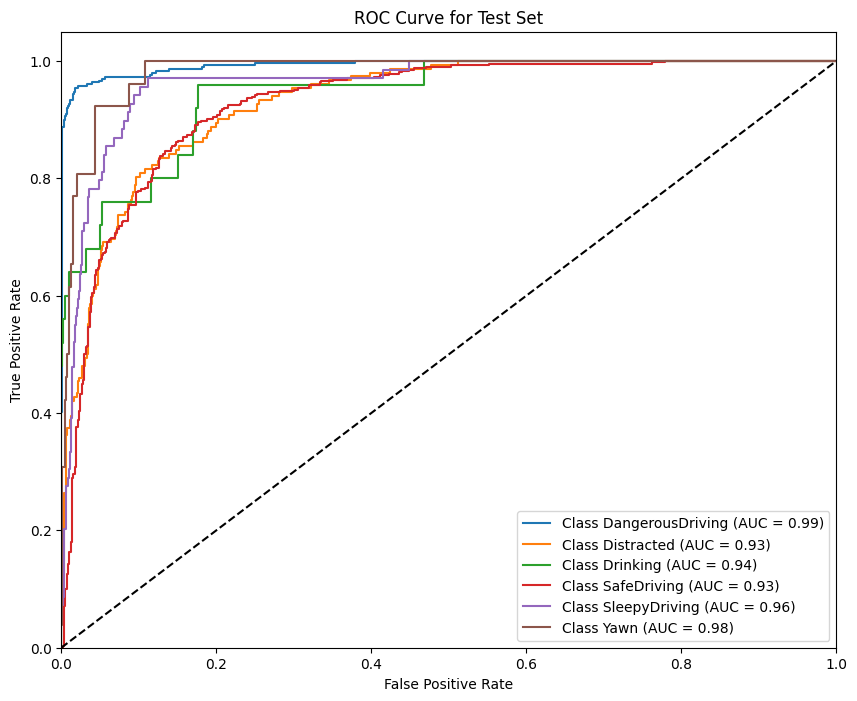

In [21]:
# Binarize the output labels
y_true_val_bin = label_binarize(y_true_val, classes=range(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_val_bin[:, i], y_score_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.show()

# Binarize the output labels
y_true_test_bin = label_binarize(y_true_test, classes=range(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_test_bin[:, i], y_score_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

<Figure size 1000x800 with 0 Axes>

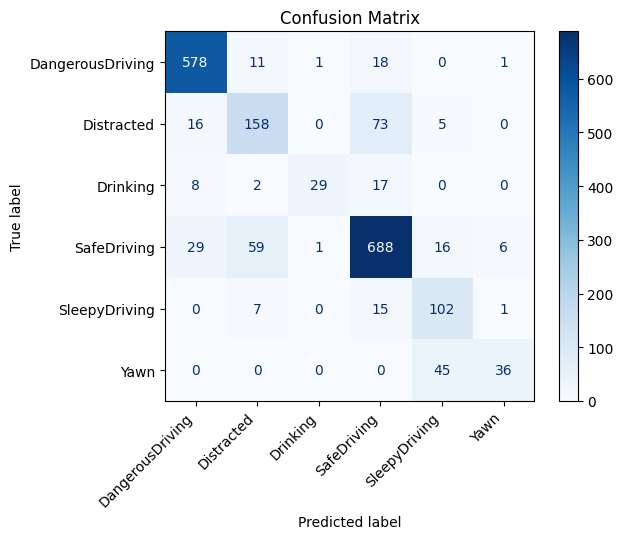

<Figure size 1000x800 with 0 Axes>

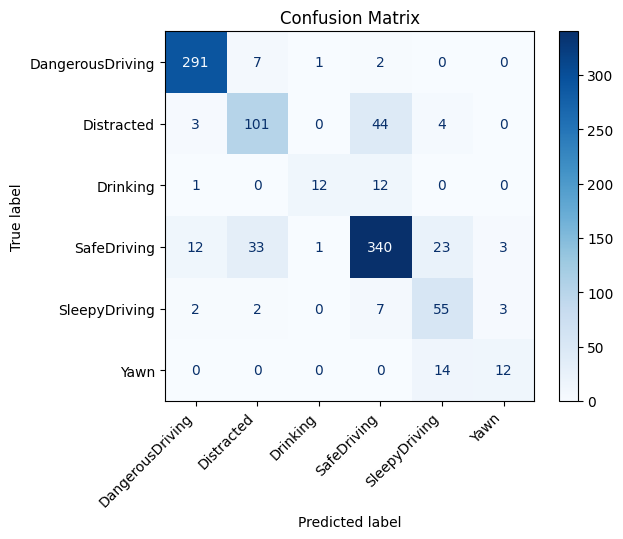

In [26]:
# Validation Data
cm = confusion_matrix(y_true_val_one_hot, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha="right") 
plt.show()

# Test Data
cm = confusion_matrix(y_true_test_one_hot, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha="right") 
plt.show()


In [33]:
# Compute metrics
precision = precision_score(y_true_val_one_hot, y_pred_val, average='weighted')  # Weighted for multi-class
accuracy = accuracy_score(y_true_val_one_hot, y_pred_val)
f1 = f1_score(y_true_val_one_hot, y_pred_val, average='weighted')
recall = recall_score(y_true_val_one_hot, y_pred_val, average='weighted')

# Print results with new lines
print("\n=====================================")
print(f" Performance Metrics for Validation Set")
print("=====================================")
print(f"Precision  : {precision:.4f}")
print(f"Accuracy   : {accuracy:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"Recall     : {recall:.4f}")
print("=====================================\n")

# Compute metrics
precision = precision_score(y_true_test_one_hot, y_pred_test, average='weighted')  # Weighted for multi-class
accuracy = accuracy_score(y_true_test_one_hot, y_pred_test)
f1 = f1_score(y_true_test_one_hot, y_pred_test, average='weighted')
recall = recall_score(y_true_test_one_hot, y_pred_test, average='weighted')

# Print results with new lines
print("\n=====================================")
print(f" Performance Metrics for Test Set")
print("=====================================")
print(f"Precision  : {precision:.4f}")
print(f"Accuracy   : {accuracy:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"Recall     : {recall:.4f}")
print("=====================================\n")




 Performance Metrics for Validation Set
Precision  : 0.8315
Accuracy   : 0.8278
F1 Score   : 0.8244
Recall     : 0.8278


 Performance Metrics for Test Set
Precision  : 0.8274
Accuracy   : 0.8234
F1 Score   : 0.8221
Recall     : 0.8234



# 3. Train and Evaluation functions

# 4. Model training

# 5. Model evaluation